# Estudio comparativo de algoritmos en un problema de k-armed bandit

*Description:* El experimento compara el rendimiento de algoritmos UCB en un problema de k-armed bandit.
Se generan gráficas de recompensas promedio para cada algoritmo.

    Authors: Jesús Verdú Chacón
             Jorge López Abad
    Emails: jesus.v.c@um.es
            jorge.lopeza@um.es
    Date: 2025/01/29

This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.

For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html



## Preparación del entorno


In [1]:
#@title Copiar el repositorio.

!git clone https://github.com/JyJumu/EML.git
!cd EML/

Cloning into 'EML'...
remote: Enumerating objects: 299, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 299 (delta 62), reused 0 (delta 0), pack-reused 196 (from 1)
Receiving objects: 100% (299/299), 409.16 KiB | 7.44 MiB/s, done.
Resolving deltas: 100% (171/171), done.


In [2]:
!ls -R /content/EML


/content/EML:
algorithms  arms  plotting  README.md  ucb_EML_normal.ipynb

/content/EML/algorithms:
algorithm.py  epsilon_greedy.py  gradiente.py  __init__.py  softmax.py	ucb1.py  ucb2.py

/content/EML/arms:
armbernoulli.py  armbinomial.py  armnormal.py  arm.py  bandit.py  __init__.py

/content/EML/plotting:
__init__.py  plotting.py


In [3]:
#@title Importamos todas las clases y funciones

import sys

# Añadir los directorio fuentes al path de Python
#sys.path.append('/content/EML')
sys.path.append('/content/EML')


# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
from typing import List
import matplotlib.pyplot as plt

from algorithms import Algorithm, EpsilonGreedy, UCB1, UCB2, Softmax, Gradiente
from arms import ArmNormal, Bandit, ArmBernoulli, ArmBinomial
from plotting import plot_average_rewards, plot_optimal_selections, plot_regret, plot_arm_statistics, plot_arm_num_choices


['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', '/content/EML']


## Experimento

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado.
Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan dos algoritmos epsilon-greedy con diferentes valores de epsilon. Se estudia la evolución de cada política  en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recompensas obtenidas en esas 500 veces.

In [4]:
def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    optimal_arm = bandit.optimal_arm  # Necesario para calcular el porcentaje de selecciones óptimas.
    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.
    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.
    arm_stats = [{'mean_rewards': np.zeros(bandit.k), 'selections': np.zeros(bandit.k)} for _ in algorithms]

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.
    regret_accumulated = np.zeros((len(algorithms), steps))  # Matriz para almacenar el regret acumulado.
    optimal_reward = bandit.pull_arm(optimal_arm)

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        total_rewards_per_algo = np.zeros(len(algorithms)) # Acumulador de recompensas por algoritmo. Necesario para calcular el promedio.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm() # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                arm_stats[idx]['mean_rewards'][chosen_arm] += reward # Actualizar la ganancia del brazo seleccionado por el algoritmo.
                arm_stats[idx]['selections'][chosen_arm] += 1 # Actualizar el número de selecciones del brazo seleccionado por el algoritmo.
                if isinstance(algo, Gradiente):
                    algo.update(chosen_arm, reward, step) # Actualizar el valor estimado del brazo seleccionado.
                else:
                    algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.
                rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.

                # Modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

                regret_accumulated[idx, step] = step*optimal_reward - total_rewards_per_algo[idx]

    rewards /= runs

    # Calcular el porcentaje de selecciones óptimas y almacenar en optimal_selections
    optimal_selections = (optimal_selections / runs) * 100
    regret_accumulated /= runs
    for stat in arm_stats:
        stat['mean_rewards'] /= runs
        stat['selections'] /= runs

    return rewards, optimal_selections, regret_accumulated, arm_stats


## Ejecución del experimento

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución gaussina con desviación 1. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan 3 algoritmos epsilon greedy para valores epsilon: 0.0, 0.01, y 0.1.

In [5]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBinomial.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definimos un algoritmo UCB
algorithms = [Softmax(k=k, tau=0.1), Softmax(k=k, tau=1), Gradiente(k=k, alfa=0.1), Gradiente(k=k, alfa=0.4)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regret_accumulated, arm_stats = run_experiment(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmBinomial(n=7, p=0.8), ArmBinomial(n=8, p=0.6), ArmBinomial(n=7, p=0.45), ArmBinomial(n=7, p=0.06), ArmBinomial(n=8, p=0.33), ArmBinomial(n=8, p=0.71), ArmBinomial(n=6, p=0.06), ArmBinomial(n=8, p=0.83), ArmBinomial(n=6, p=0.0), ArmBinomial(n=5, p=0.62)
Optimal arm: 8 with expected reward=6.64


## Visualización de los resultados

### Recompensa promedio vs pasos de tiempo

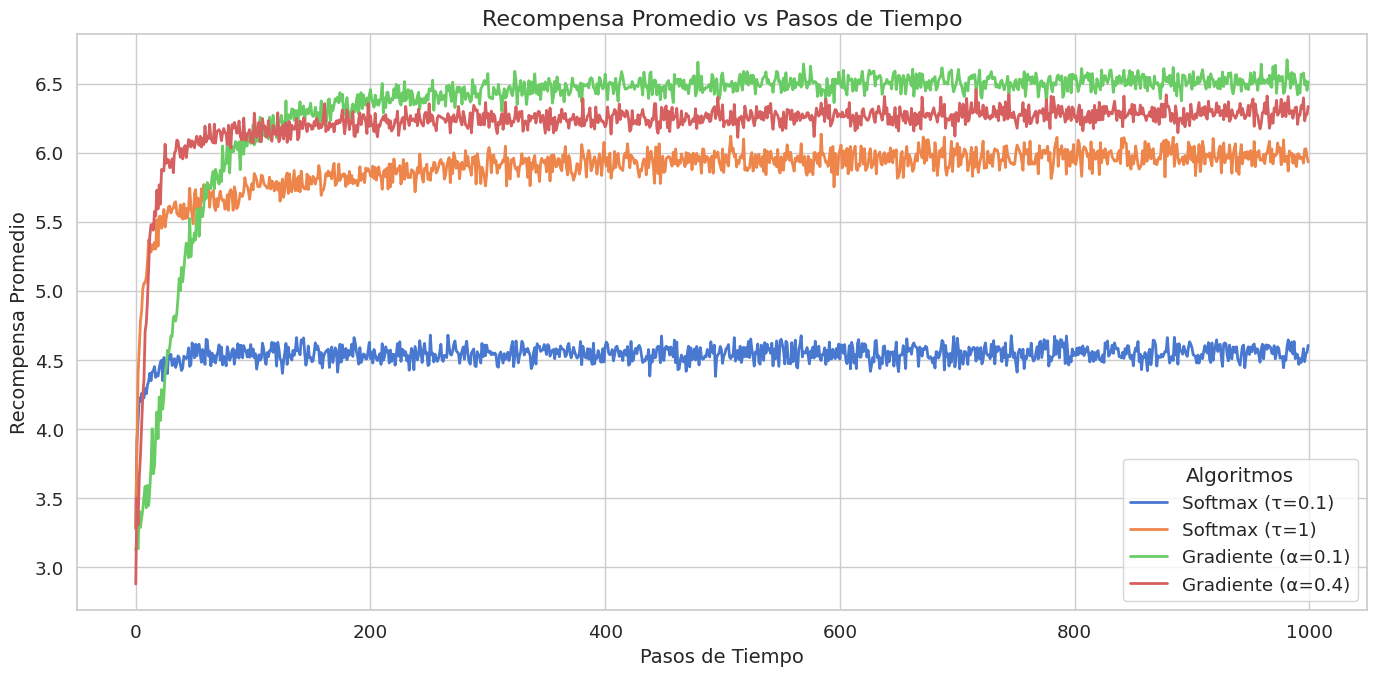

In [6]:
# Graficar los resultados
plot_average_rewards(steps, rewards, algorithms)

**ANÁLISIS DETALLADO DE LA IMAGEN**

La imagen muestra un gráfico de líneas titulado **"Recompensa Promedio vs Pasos de Tiempo"**, donde se analiza el desempeño de diferentes estrategias de los algoritmos **softmax** y **gradiente de preferencias** en un entorno de multi-armed bandit. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra la **recompensa promedio** obtenida por cada algoritmo.


1. **En las tres primeras gráficas de esta sección, las cuatro líneas de colores distintos representan diferentes valores de α y τ en los algoritmos de la familia softmax:**
   - **Azul (softmax con τ=0.1):** Cuanto menor sea el valor de τ, más se favorecen las acciones con mayor estimación de recompensa. Es por ello que en este caso nos encontramos con una estrategia completamente **explotadora**, es decir, que siempre elige la acción que ha dado la mejor recompensa hasta ahora sin explorar nuevas opciones.
   - **Naranja (softmax con τ=1):** Representa una estrategia en la cual las probabilidades se distribuyen más uniformemente, tendiendo a ser más exploradora.
   - **Verde (gradiente de preferencias con α = 0.1):** El parámetro α representa la tasa de aprendizaje con la que se actualizan las preferencias de las acciones. Cuanto menor sea el valor, más lentamente se actualizarán las preferencias. Es por ello que en este caso nos encontramos con una estrategia más exploradora, pues explora antes de converger.
   - **Rojo (gradiente de preferencias con α = 0.4):** Representa una estrategia en la que la tasa de aprendizaje es mayor, por lo que se le da más peso a las recompensas recientes, redundando en una estrategia más explotadora.

2. **Crecimiento de la recompensa promedio:**
   - La línea **verde (gradiente de preferencias con α = 0.1)** presenta un gran crecimiento inicial. Este crecimiento se reduce al acercarse al paso cien y termina convergiendo con una recompensa promedio de 6.5.
   - La línea **roja (gradiente de preferencias con α = 0.4)** presenta un crecimiento inicial mayor y converge con mayor rapidez. Empero, se estanca en una recompensa proedio inferior.
   - La línea **naranja (softmax con τ=1)** presenta un crecimiento similar al de la línea roja, aunque se estanca un poco antes y apenas llega a una recompensa promedio de 6.
   - La línea **azul (softmax con τ=0.1)** se mantiene en un nivel bajo de recompensa. Crece al mismo ritmo que las líneas roja y naranja y queda con una recompensa promedio de 4.5.

---





### Porcentaje de selección del brazo óptimo vs pasos de tiempo

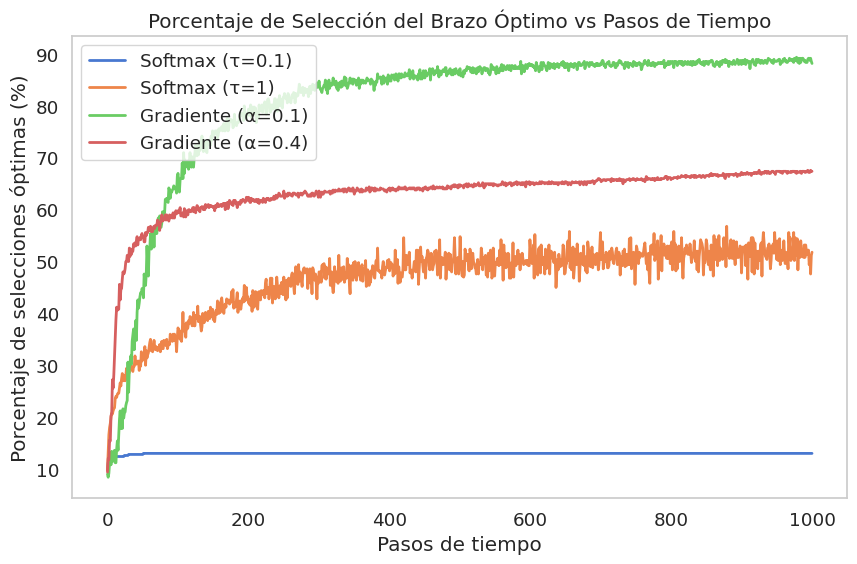

In [7]:
plot_optimal_selections(steps, optimal_selections, algorithms)

**ANÁLISIS DETALLADO DE LA IMAGEN**

La imagen muestra un gráfico de líneas titulado **"Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo"**. Al igual que en la imagen anterior y en las venideras, en la gráfica se analiza el desempeño de diferentes estrategias de los dos algoritmos de la familia **softmax** en un entorno de multi-armed bandit. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestran es este caso el porcentaje promedio de selección del brazo óptimo la **recompensa promedio** obtenida por cada algoritmo.

* **Crecimiento del porcentaje de selección del brazo óptimo:**
   - La línea **verde (gradiente con α=0.1)** presenta un notable crecimiento inicial hasta el paso 200. A partir de entonces, el crecimiento se reduce notablemente, alcanzando un porcentaje de selecciones óptimas de casi el noventa porciento.
   - La línea **roja (gradiente con α=0.4)** presenta un crecimiento inicial superior pero se estanca unos pasos de tiempo antes, alcanzando un porcentaje de selecciones óptimas de alrededor del 65%.
   - La línea **naranja (softmax con τ=1)** presenta un crecimiento inicial similar a la línea roja. Sin embargo, este crecimiento se reduce considerablemente en los primeros pasos de tiempo. A partir de entonces, la línea sigue creciendo a menor ritmo y termina estancándose en un 50%. Nótese que el porcentaje de selecciones óptimas tiene una gran oscilación a partir de los 200 pasos de tiempo.
   - La línea **azul (softmax con τ=0.1)** muestra un crecimiento prácticamente nulo. Esto indica que no ha sido capaz de encontrar el brazo óptimo.

---





### Arrepentimiento acumulado vs pasos de tiempo

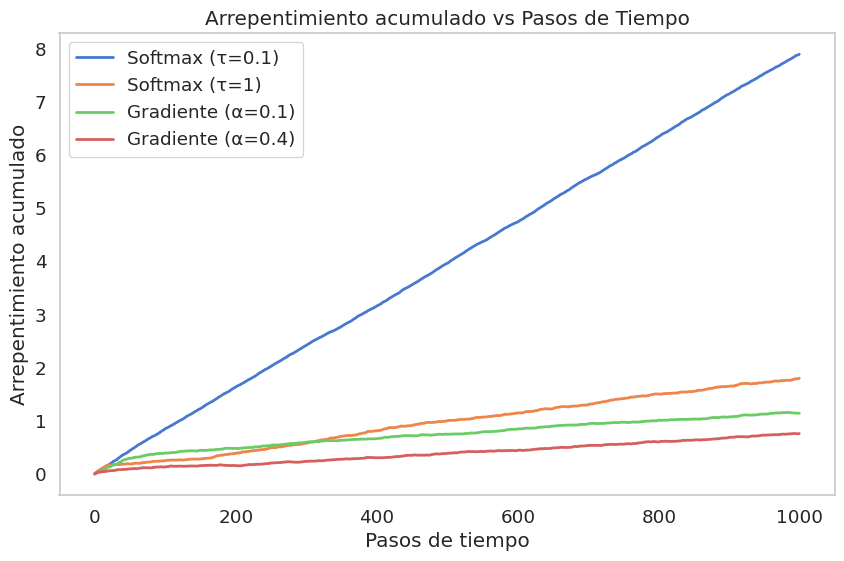

In [8]:
plot_regret(steps, regret_accumulated, algorithms)

**ANÁLISIS DETALLADO DE LA IMAGEN**

La imagen muestra un gráfico de líneas titulado **"Arrepentimiento acumulado vs Pasos de Tiempo"**. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el arrepentimiento acumulado de cada algoritmo.

* **Crecimiento del arrepentimiento acumulado:**
   - La línea **verde (gradiente de preferencias con α=0.1)** tiene un crecimiento reducido, llegando a un arrepentimiento acumulado de casi 1 punto.
   - La línea **roja (gradiente de preferencias con α=0.4)** presenta el menor crecimiento de todos, no llegando a alcanzar un punto de arrepentimiento acumulado.
   - La línea **naranja (softmax con τ=1)** presenta un crecimiento superior, acercándose casi a dos puntos de arrepentimiento acumulado al llegar a los últimos pasos de tiempo.
   - La línea **azul (softmax con τ=0.1)** presenta el mayor arrepentimiento de todas con gran diferencia. Esto muestra que no ha sido capaz de encontrar el brazo óptimo.
---





### Porcentaje de selección del brazo óptimo vs pasos de tiempo

<Figure size 1000x600 with 0 Axes>

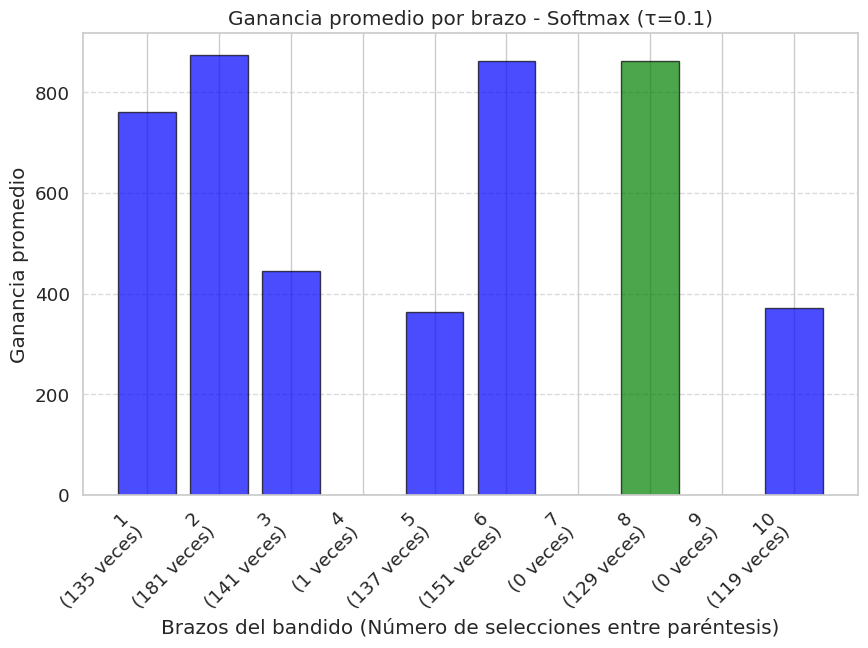

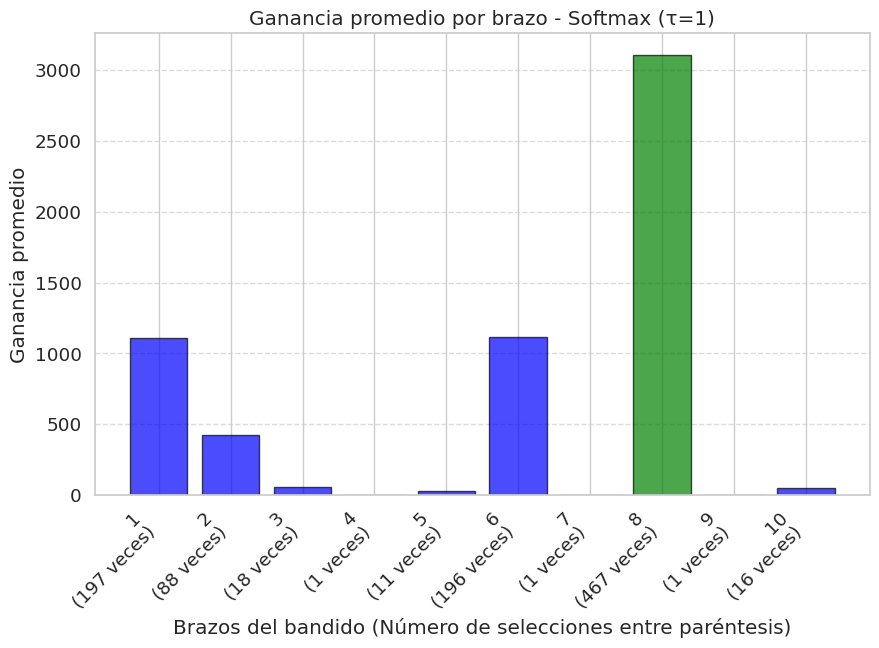

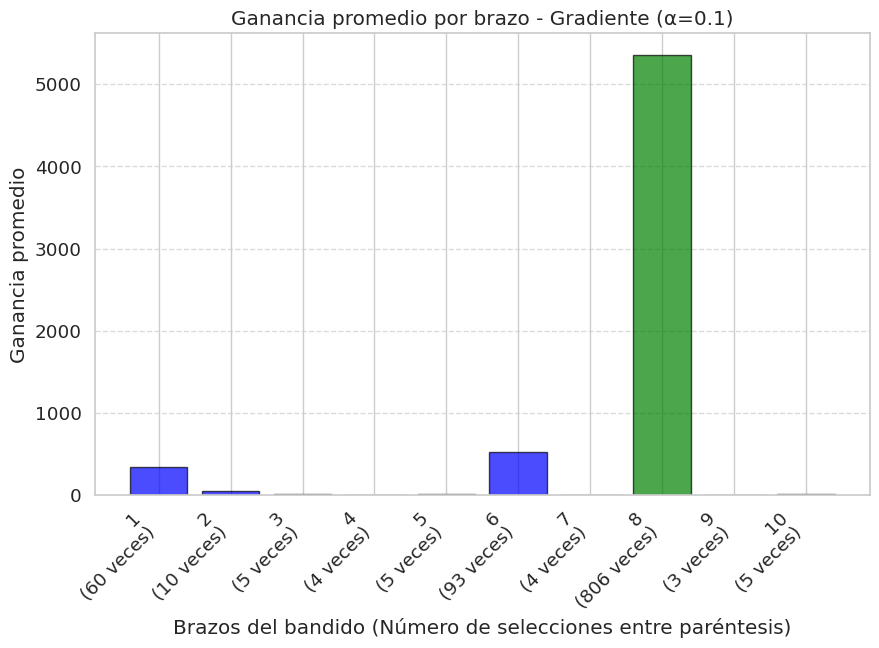

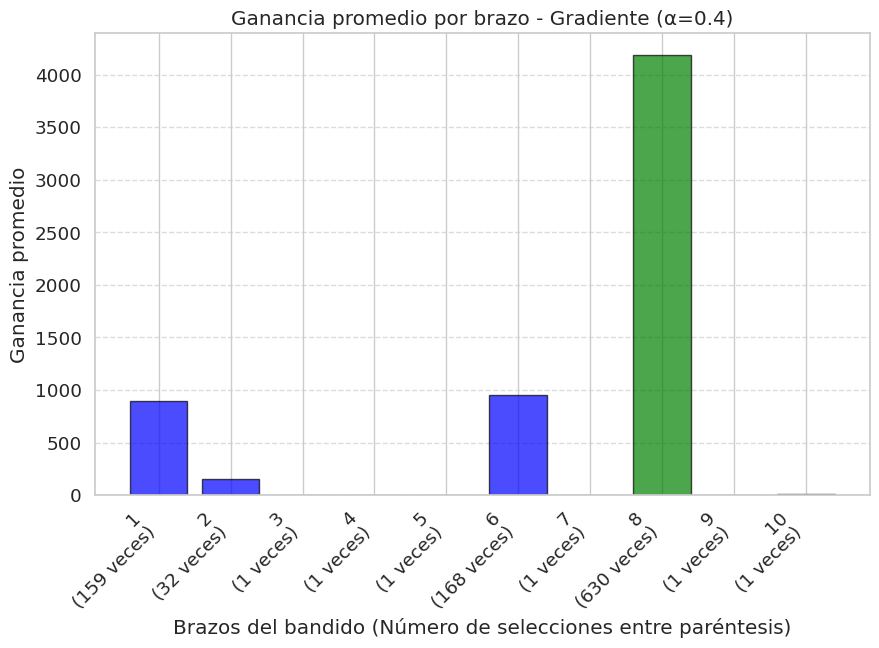

In [9]:
plot_arm_statistics(arm_stats, algorithms, k, optimal_arm)

**ANÁLISIS DETALLADO DE LA IMAGEN**

La imagen muestra tres gráficos de barras, cada uno titulado **"Ganancia promedio por brazo"**. En el eje **x** se representan los **brazos del bandido**, indicando en paréntesis el número de selecciones por brazo; mientras que en el eje **y** se muestra la ganancia obtenida de cada brazo. Además, la barra del brazo óptimo se muestra en verde y la del resto de brazos en azul.

1. **Las cuatro gráficas que se muestran se corresponden a diferentes valores de τ en el algoritmo softmax y de α en el algoritmo gradiente de preferencias:**
   - **Primera gráfica (softmax con τ=0.1):** Representa los resultados de la estrategia completamente **explotadora** para el algoritmo softmax.
   - **Segunda gráfica (softmax con τ=0.01):** Representa una estrategia más explordora del algoritmo softmax.
   - **Tercera gráfica (gradiente con α=0.1):** Representa una estrategia exploradora del algoritmo gradiente de preferencias.
   - **Cuarta gráfica (gradiente con α=0.4):** Representa una estrategia explotadora del algoritmo gradiente de preferencias.

2. **Ganancia y número de selecciones promedio por brazo:**
   - La **primera gráfica (softmax con τ=0.1)** se corresponde con la estrategia más explotadora de softmax. Podemos observar que se seleccionan todos los brazos y que del 4 al 10, el número de selecciones es similar. Además, pese a que la ganancia obtenida para el brazo óptimo sea la mayor de todas, este no ha sido el brazo más elegido.
   - La **segunda gráfica (softmax con τ=1)** muestra que el algoritmo es capaz de seleccionar mayoritariamente el brazo óptimo, aunque yerra en numerosas ocasiones, dando lugar a que otros brazos sean elegidos un número de veces similar aunque menor.
   - La **tercera gráfica (gradiente con α=0.1)** muestra que se consigue seleccionar el brazo óptimo en la amplia mayoría de las ocasiones. Asimismo, la ganancia obtenida en este caso es notablemente superior a la obtenida con softmax y con el otro valor de α.
   - La **cuarta gráfica (gradiente con α=0.1)** muestra un rendimiento peor que para el otro valor de α, pues la ganancia es menor y el número de selecciones del brazo óptimo también es menor. Aún así, el rendimiento es superior al logrado con softmax.

---





## Conclusiones

Hemos estudiado un  **experimento de toma de decisiones secuenciales**, modelado con un **Multi-Armed Bandit (MAB)**. Este problema es fundamental en el aprendizaje por refuerzo y la teoría de decisiones. La idea principal es que un agente debe aprender cuál es la mejor acción (brazo del bandit) a partir de la experiencia acumulada. Para este estudio nos hemos centrado solo en el estudio del algoritmo epsilon-greedy, llegando a las siguientes conclusiones a partir de los resultados obtenidos y la gráfica generada:

#### **1. Exploración vs Explotación**
El algoritmo **softmax** equilibra la exploración y la explotación:
- **Explotación (τ<1)**: Favorece más las acciones con mayor recompensa estimada.
- **Exploración (τ>1)**: Distribuye las probabilidades más uniformemente.

Por otro lado, el algoritmo **gradiente de preferencias** también equilibra la exploración y la explotación:
- **Explotación (valores altos de α)**: Las recompensas recientes tienen mayor eso, por lo que las acciones con mayor recompensa se favorecen rápidamente, dando lugar a que el algoritmo converja rápido a una estrategia y que sea pueda estancar en un
máximo local.
- **Exploración (valores bajos de α)**: Las preferencias se actualizan más lentamente, lo que redunda en que se da más oportunidad a todas las acciones antes de decidir una estrategia clara.

Los gráficos de línea y de barras confirman este comportamiento:
- **Gradiente con α=0.1 (verde en los gráficos de línea y el tercero en los de barras)**: Obtiene la mejor recompensa promedio a lo largo del tiempo porque explora lo suficiente como para encontrar rápidamente el mejor brazo, permitiendo así obtener la mayor ganancia y el mayor número de selecciones óptimas entre todos los algoritmos que hemos probado en este notebook.
- **Gradiente con α=0.01 (rojo en los gráficos de línea y el último en los de barras)**: Explora menos, por lo que no logra encontrar el brazo óptimo tan rápidamente. El porcentaje de selección del brazo óptimo es inferior al obtenido con α=0.1. Igualmente, el arrepentimiento promedio es mayor y el número de elecciones óptimas y la ganancia total es inferior.
- **Softmax con τ=1 (naranja en los gráficos de línea y el segundo en los de barras)**: Gracias a la exploración que realiza, logra encontrar el brazo óptimo. Sin embargo, no realiza un número significativo de elecciones óptimas, lo cual redunda en que la ganancia obtenida es inferior a la lograda con gradiente de preferencias.
- **Softmax con τ=0.1 (azul en los gráficos de línea y el primero en los de barras)**: Apenas explora y no logra alcanzar un número significativo de elecciones óptimas, eligiendo el brazo óptimo menos veces que otros brazos del bandido.

#### **2. Convergencia de los algoritmos**
Si comparamos el rendimiento obtenido entre los valores explotadores y exploradores de cada algoritmo notamos que los valores exploradores ofrecen un mejor rendimiento que los explotadores. Esto se debe a que:
- Al principio, el algoritmo **no tiene información suficiente** sobre cuál es el mejor brazo.
- Con el tiempo, al realizar exploraciones, descubre cuál es el mejor brazo y empieza a explotarlo más.
- Un **balance entre exploración y explotación** es clave para maximizar la recompensa a largo plazo.

Igualmente, si comparamos el rendimiento ofrecido por ambos algoritmos, notamos que gradiente de preferencias ofrece, en todos los casos, un rendimiento mayor que el logrado por softmax.

#### **3. Aplicaciones y conclusiones**
- En problemas de toma de decisiones **(ejemplo: recomendaciones, optimización de anuncios, medicina personalizada)**, una estrategia de exploración moderada como **α=0.1** es más efectiva para encontrar la mejor opción rápidamente.
- **Una exploración reducida (α=0)** lleva a un desempeño deficiente, ya que el agente puede quedarse atrapado en una elección subóptima.

Análogamente, el uso de las preferencias en el **gradiente de preferencias** permite un aprendizaje más preciso y dirigido de las políticas, pues el agente ajusta las probabilidades a medida que se evalúan las recompensas.

Esto contrasta con el algoritmo **softmax**, pues este último ajusta las probabilidades en función de las estimaciones de valor de las acciones, lo cual es más indirecto y depende d elas estimaciones, las cuales a veces tienen ruido o son imprecisas.

En conclusión, **los gráficos muestran cómo un nivel adecuado de exploración mejora significativamente el rendimiento del algoritmo en un entorno de aprendizaje por refuerzo y que el uso de las preferencias en gradiente de preferencias logra un mejor rendimiento**. 🚀